<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_BRAZPD_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - BRAZPD Dataset
This notebook is based on the [Batch-DLG Evolution - Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the IRIS Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked. We now modify the code to run on the BRAZPD dataset.

# Setting up Libaries and Utilities

In [64]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import random

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.13.1+cu116
Running on cpu


In [4]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
!cp 'drive/MyDrive/UROP/Project Files/BRAZPD_UnofM_all.csv' 'BRAZPD_UnofM_all.csv'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess BRAZPD Dataset

In [ ]:
# convert categorical variables to onehot

In [5]:
# import BRAZPD dataset
import pandas as pd
import numpy as np
import os

filename = 'BRAZPD_UnofM_all.csv'
df = pd.read_csv(filename, engine='python', encoding = "ISO-8859-1")
print(df.shape)
df['followup1yfull'] = df['Followup'].apply(lambda x: 1 if x >= 12 else 0)

(5707, 1735)


In [6]:
# grab baseline features and target
baseline_set = ['CenterSizenpatients', 'Age', 'IncidentinPD', 'PrevalentinPDNet', \
                'Primaryrenaldisease', 'PreviousHD',\
                'Previoustx', 'DaviesScore', 'Peripheralarterydisease',\
                'Cancer', 'Stroke','Hypertension', 'HIV', 'HCV', 'HBC', 'Gender', 'Race',\
                'Familyincome', 'predialysiscare',\
                'timeofpredialysiscare', 'Educationdic4y', 'Region',\
                'Centerexperiencepatientyear', 'BMI', 'Distancefromcenter']
baseline_set_numerical = ['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore',\
                          'Familyincome', 'timeofpredialysiscare', 'Centerexperiencepatientyear',\
                          'BMI', 'Distancefromcenter']
baseline_set_categorical = ['IncidentinPD', 'PrevalentinPDNet', 'PreviousHD', 'Previoustx', \
                            'Peripheralarterydisease', 'Cancer', 'Stroke', 'Hypertension', \
                            'HIV', 'HCV', 'HBC', 'Gender', 'Race', 'predialysiscare', \
                            'Educationdic4y', 'Region']
# NOTE: BMI, Familyincome, and Distancefromcenter are in the numerical set but
# they are given as categories (not known whether ordered); possibly other variables too

In [ ]:
# def data_to_onehot(baseline_set):
#     res = torch.zeros(df[baseline_set].shape[0], 0)
#     for name in baseline_set:
#         maxval = max(df[name])
#         print(df[name].to_numpy())
#         cnt = maxval+1
#         onehot_data = torch.zeros(res.shape[0], cnt)
#         #onehot_data.scatter_(df[name]).scatter_(1, df[], 1)
#
# data_to_onehot(baseline_set)

# def encode_and_bind(original_dataframe, feature_to_encode):
#     #dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
#     print(pd.get_dummies(df[baseline_set]))
#     res = pd.concat([original_dataframe, dummies], axis=1)
#     return(res)

# encode_and_bind(df, baseline_set[2])

print(pd.concat([pd.get_dummies(df[name]) for name in baseline_set], axis=1))

      1  1  0  1  0  1  0  1  0  1  ...  5  0  1  0  1  1  2  3  4  5
0     1  1  1  0  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
1     1  1  1  0  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
2     1  1  1  0  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
3     1  1  1  0  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
4     1  1  0  1  1  0  1  0  1  0  ...  0  0  1  0  1  0  1  0  0  0
...  .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
5702  1  1  1  0  1  0  1  0  1  0  ...  0  0  1  1  0  0  1  0  0  0
5703  1  1  1  0  1  0  1  0  1  0  ...  0  0  1  1  0  0  1  0  0  0
5704  1  1  1  0  1  0  1  0  1  0  ...  0  0  1  1  0  0  1  0  0  0
5705  1  1  0  1  1  0  1  0  1  0  ...  0  0  1  1  0  0  1  0  0  0
5706  1  1  1  0  1  0  1  0  1  0  ...  0  1  0  1  0  0  1  0  0  0

[5707 rows x 36 columns]


In [49]:
# *** load categorical ***
def load_categorical(inp_cnt, target = 'followup1yfull'):
    baseline_set = np.array(baseline_set_categorical)
    assert inp_cnt <= len(baseline_set)
    idxs = list(RandomSampler(baseline_set, num_samples=inp_cnt))
    idxs.sort()
    idxs = np.array(idxs)
    
    # print(baseline_set)
    # print(baseline_set[idxs])
    baseline_set = baseline_set[idxs]

    targets = [target] # ["death_event_1y"]

    X_baseline = pd.concat([pd.get_dummies(df[name]) for name in baseline_set], axis=1).copy(); X_baseline.fillna(0, inplace=True); X_baseline = X_baseline.to_numpy()
    Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

    print('categorical variables:', baseline_set)
    print(X_baseline)
    print(Y_baseline)

    return X_baseline, Y_baseline

load_categorical(inp_cnt=3)

categorical variables: ['Peripheralarterydisease' 'Cancer' 'Educationdic4y']
[[1 0 1 0 0 1]
 [1 0 1 0 0 1]
 [1 0 1 0 0 1]
 ...
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


(array([[1, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1],
        ...,
        [1, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 0]], dtype=uint8), array([[0],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]]))

In [43]:
# *** load numerical ***
def load_numerical(inp_cnt = 9, target = 'followup1yfull'):

    baseline_set = np.array(baseline_set_numerical)
    assert inp_cnt <= len(baseline_set)
    idxs = list(RandomSampler(baseline_set, num_samples=inp_cnt))
    idxs.sort()
    idxs = np.array(idxs)
    
    # print(baseline_set)
    # print(baseline_set[idxs])
    baseline_set = baseline_set[idxs]

    targets = [target] # ["death_event_1y"]

    X_baseline = df[baseline_set].copy(); X_baseline.fillna(X_baseline.mean(), inplace=True); X_baseline = X_baseline.to_numpy()
    Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

    print('numerical variables:', baseline_set)
    print(X_baseline)
    print(Y_baseline)

    return X_baseline, Y_baseline

X_baseline, Y_baseline = load_numerical(5)

numerical variables: ['Primaryrenaldisease' 'DaviesScore' 'timeofpredialysiscare' 'BMI'
 'Distancefromcenter']
[[81.   0.  36.  20.7  1. ]
 [ 0.   0.  26.  28.3  1. ]
 [81.   1.  72.  31.5  1. ]
 ...
 [50.   0.  10.  23.5  1. ]
 [50.   0.  11.  35.   1. ]
 [81.   0.   0.  20.6  3. ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [44]:
# rescale BRAZPD dataset
def rescale_data(X_baseline, Y_baseline):
    dst_length = X_baseline.shape[0]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X_baseline)
    print(scaled_data)

    torch.manual_seed(100)  # fix a given set of patients
    train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), dst_length - int(dst_length*4/5)])
    train_indices = train_indices.indices
    test_indices = test_indices.indices
    train_data = scaled_data[train_indices]; train_target = Y_baseline[train_indices]
    test_data = scaled_data[test_indices]; test_target = Y_baseline[test_indices]

    input_dim = X_baseline.shape[1]
    output_dim = 2
    print('dimensions: ', input_dim, output_dim)

    return train_data, train_target, test_data, test_target, input_dim, output_dim, scaler

train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = rescale_data(X_baseline, Y_baseline)

[[ 0.68738219 -1.03516117  0.63675017 -0.86670574 -0.70452708]
 [-1.44938318 -1.03516117  0.30090303  0.78158174 -0.70452708]
 [ 0.68738219  0.09831251  1.84579987  1.47559752 -0.70452708]
 ...
 [-0.13039221 -1.03516117 -0.23645239 -0.25944193 -0.70452708]
 [-0.13039221 -1.03516117 -0.20286768  2.23467729 -0.70452708]
 [ 0.68738219 -1.03516117 -0.57229953 -0.88839374  1.0935143 ]]
dimensions:  5 2


# Setting up Fully Connected Neural Network

In [45]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [46]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet(input_dim, output_dim).to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [55]:
# setup new FCnet on a subset of the baseline numerical features
def setup_net(inp_cnt_num, inp_cnt_cat):
    X_baseline_num, Y_baseline_num = load_numerical(inp_cnt_num)
    X_baseline_cat, Y_baseline_cat = load_categorical(inp_cnt_cat)
    print(type(X_baseline_num), type(X_baseline_cat))
    X_baseline = np.hstack((X_baseline_num, X_baseline_cat))
    Y_baseline = Y_baseline_num

    train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = rescale_data(X_baseline, Y_baseline)
    net = FcNet(input_dim, output_dim).to(device)
    net.apply(weights_init)
    return net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler

net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(inp_cnt_num = 5, inp_cnt_cat = 3)

numerical variables: ['Primaryrenaldisease' 'DaviesScore' 'Familyincome'
 'timeofpredialysiscare' 'Distancefromcenter']
[[81.  0.  3. 36.  1.]
 [ 0.  0.  1. 26.  1.]
 [81.  1.  2. 72.  1.]
 ...
 [50.  0.  2. 10.  1.]
 [50.  0.  1. 11.  1.]
 [81.  0.  1.  0.  3.]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['IncidentinPD' 'PreviousHD' 'Stroke']
[[1 1 0 1 0]
 [1 1 0 1 0]
 [1 1 0 1 0]
 ...
 [1 1 0 1 0]
 [1 0 1 1 0]
 [1 1 0 1 0]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[ 0.68738219 -1.03516117  1.12721738 ... -0.85067529  0.11303665
  -0.11303665]
 [-1.44938318 -1.03516117 -0.98856278 ... -0.85067529  0.11303665
  -0.11303665]
 [ 0.68738219  0.09831251  0.0693273  ... -0.85067529  0.11303665
  -0.11303665]
 ...
 [-0.13039221 -1.03516117  0.0693273  ... -0.85067529  0.11303665
  -0.11303665]
 [-0.13039221 -1.03516117 -0.98856278 ...  1.17553668  0.11303665
  -0.11303665]
 [ 0.68738219 -1.03516117 -0.98856278 ... -0.85067529  0.113

# Train Model Normally

score: 679/1142


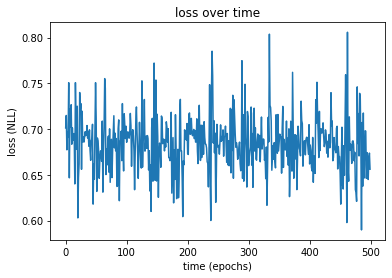

In [58]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 500
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG (not updated)

In [ ]:
#@title get batch gradient (not updated)
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

In [ ]:
#@title run batch_DLG on one batch (not updated)
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = 4, gt_onehot_label_len = 3, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Evolution

In [68]:
# results of training a model + dlg
net.apply(weights_init)
errors = []
nvars = 7
epochs = 5
batch_size = 1
dlg_rate = 1
verbose = True
for i in range(nvars):
    j = random.randint(1, i+1)
    nvars = i+1
    net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(inp_cnt_num = i+2, inp_cnt_cat = i+2-j)
    losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
        = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                            gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=200, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = True)
    
    errors.append(torch.flatten(torch.tensor(AA_REs)).numpy())
    print(f'using {nvars} variables: ', AA_REs)
#test_net(net, test_data, test_target)

numerical variables: ['Centerexperiencepatientyear' 'Distancefromcenter']
[[30.763889  1.      ]
 [30.763889  1.      ]
 [30.763889  1.      ]
 ...
 [16.416667  1.      ]
 [16.416667  1.      ]
 [16.416667  3.      ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['IncidentinPD']
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[-0.43880709 -0.70452708  0.        ]
 [-0.43880709 -0.70452708  0.        ]
 [-0.43880709 -0.70452708  0.        ]
 ...
 [-1.01264725 -0.70452708  0.        ]
 [-1.01264725 -0.70452708  0.        ]
 [-1.01264725  1.0935143   0.        ]]
dimensions:  3 2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([33.2500,  2.0000,  1.0000], dtype=torch.float64) tensor([-26.3054,   1.2694,   3.8590]) RE (AE / TN):  1.7892953565880143
closest match: assignment and relative error (%):
tensor([-26.3054,   1.2694,   3.8590], dtype=torch.float64) tensor([33.2500,  2.0000,  1.0000], dtype=torch.float64) 178.92953593076004


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([32.1667,  1.0000,  1.0000], dtype=torch.float64) tensor([-1.3189,  1.0463,  2.5507]) RE (AE / TN):  1.0411128470577313
closest match: assignment and relative error (%):
tensor([-1.3189,  1.0463,  2.5507], dtype=torch.float64) tensor([32.1667,  1.0000,  1.0000], dtype=torch.float64) 104.11128485328318


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([25.8667,  1.0000,  1.0000], dtype=torch.float64) tensor([25.8700,  1.0000,  0.9998]) RE (AE / TN):  0.00013033167990941333
closest match: assignment and relative error (%):
tensor([25.8700,  1.0000,  0.9998], dtype=torch.float64) tensor([25.8667,  1.0000,  1.0000], dtype=torch.float64) 0.013031041248655827


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([12.7500,  1.0000,  1.0000], dtype=torch.float64) tensor([12.7481,  0.9998,  1.0001]) RE (AE / TN):  0.00015220947214992348
closest match: assignment and relative error (%):
tensor([12.7481,  0.9998,  1.0001], dtype=torch.float64) tensor([12.7500,  1.0000,  1.0000], dtype=torch.float64) 0.0152242214916126


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([22.5667,  1.0000,  1.0000], dtype=torch.float64) tensor([-4.2963,  0.7726,  2.7030]) RE (AE / TN):  1.1904775546313484
closest match: assignment and relative error (%):
tensor([-4.2963,  0.7726,  2.7030], dtype=torch.float64) tensor([22.5667,  1.0000,  1.0000], dtype=torch.float64) 119.04775571580029
using 1 variables:  [[1.7892953565880143], [1.0411128470577313], [0.00013033167990941333], [0.00015220947214992348], [1.1904775546313484]]
numerical variables: ['CenterSizenpatients' 'Familyincome' 'Distancefromcenter']
[[128.   3.   1.]
 [128.   1.   1.]
 [128.   2.   1.]
 ...
 [ 66.   2.   1.]
 [ 66.   1.   1.]
 [ 66.   1.   3.]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['Stroke']
[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[-0.35269546  1.12721738 -0.70452708  0.11303665 -0.11303665]
 [-0.35269546 -0.98856278 -0.70452708  0.11

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([56.0000,  1.0000,  1.0000,  1.0000,  0.0000], dtype=torch.float64) tensor([153.7789,   3.6308,   3.4346,   0.9779,  -0.4621]) RE (AE / TN):  1.746409598432268
closest match: assignment and relative error (%):
tensor([153.7789,   3.6308,   3.4346,   0.9779,  -0.4621], dtype=torch.float64) tensor([56.0000,  1.0000,  1.0000,  1.0000,  0.0000], dtype=torch.float64) 174.64096999150607


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([193.,   1.,   1.,   1.,   0.], dtype=torch.float64) tensor([ 1.9292e+02,  9.9892e-01,  9.9827e-01,  9.9998e-01, -4.3864e-04]) RE (AE / TN):  0.00043250255822952275
closest match: assignment and relative error (%):
tensor([ 1.9292e+02,  9.9892e-01,  9.9827e-01,  9.9998e-01, -4.3864e-04],
       dtype=torch.float64) tensor([193.,   1.,   1.,   1.,   0.], dtype=torch.float64) 0.043251149109099


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([50.,  1.,  1.,  1.,  0.], dtype=torch.float64) tensor([5.0006e+01, 9.9995e-01, 1.0000e+00, 1.0000e+00, 1.5869e-04]) RE (AE / TN):  0.00012318673512292017
closest match: assignment and relative error (%):
tensor([5.0006e+01, 9.9995e-01, 1.0000e+00, 1.0000e+00, 1.5869e-04],
       dtype=torch.float64) tensor([50.,  1.,  1.,  1.,  0.], dtype=torch.float64) 0.012321641709550513


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([172.,   2.,   1.,   1.,   0.], dtype=torch.float64) tensor([336.3599,   4.8458,   3.5550,   0.9742,  -0.5602]) RE (AE / TN):  0.9557479038254283
closest match: assignment and relative error (%):
tensor([336.3598,   4.8458,   3.5550,   0.9742,  -0.5602], dtype=torch.float64) tensor([172.,   2.,   1.,   1.,   0.], dtype=torch.float64) 95.57478248767711


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([42.,  2.,  3.,  1.,  0.], dtype=torch.float64) tensor([92.1868,  3.2584,  4.1336,  0.9587, -0.4409]) RE (AE / TN):  1.190933538533671
closest match: assignment and relative error (%):
tensor([92.1868,  3.2584,  4.1336,  0.9587, -0.4409], dtype=torch.float64) tensor([42.,  2.,  3.,  1.,  0.], dtype=torch.float64) 119.09335088016076
using 2 variables:  [[1.746409598432268], [0.00043250255822952275], [0.00012318673512292017], [0.9557479038254283], [1.190933538533671]]
numerical variables: ['Primaryrenaldisease' 'Centerexperiencepatientyear' 'BMI'
 'Distancefromcenter']
[[81.       30.763889 20.7       1.      ]
 [ 0.       30.763889 28.3       1.      ]
 [81.       30.763889 31.5       1.      ]
 ...
 [50.       16.416667 23.5       1.      ]
 [50.       16.416667 35.        1.      ]
 [81.       16.416667 20.6       3.      ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['PrevalentinPDNet' 'Stroke' 'HIV']
[[1 1 0 1 0]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([8.1000e+01, 1.6417e+01, 2.5800e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) tensor([-171.3325,  -42.3555,   20.6365,   -1.5348,    5.6009,    0.8090,
          -0.4803,    0.3760,    0.2706]) RE (AE / TN):  2.9924063217319414
closest match: assignment and relative error (%):
tensor([-171.3325,  -42.3555,   20.6365,   -1.5348,    5.6009,    0.8090,
          -0.4803,    0.3760,    0.2706], dtype=torch.float64) tensor([8.1000e+01, 1.6417e+01, 2.5800e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) 299.24062818461584


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([8.1000e+01, 2.7117e+01, 3.2000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) tensor([ 8.1002e+01,  2.7119e+01,  3.2000e+01,  1.0000e+00,  9.9925e-01,
         1.0000e+00, -2.6140e-05,  1.0000e+00, -5.7399e-06]) RE (AE / TN):  3.90784139789395e-05
closest match: assignment and relative error (%):
tensor([ 8.1002e+01,  2.7119e+01,  3.2000e+01,  1.0000e+00,  9.9925e-01,
         1.0000e+00, -2.6140e-05,  1.0000e+00, -5.7399e-06],
       dtype=torch.float64) tensor([8.1000e+01, 2.7117e+01, 3.2000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) 0.0039054133444298774


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.0000e+01, 3.2972e+01, 1.8700e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) tensor([-71.1898,  -8.5371,  18.4191,  -0.5263,   3.0567,   1.2679,  -0.2541,
          0.5134,   0.2095]) RE (AE / TN):  2.0410429010741686
closest match: assignment and relative error (%):
tensor([-71.1898,  -8.5371,  18.4191,  -0.5263,   3.0567,   1.2679,  -0.2541,
          0.5134,   0.2095], dtype=torch.float64) tensor([5.0000e+01, 3.2972e+01, 1.8700e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) 204.10428470184306


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([0.0000e+00, 5.9042e+01, 2.1200e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) tensor([-1.1012e-03,  5.9044e+01,  2.1202e+01,  1.0002e+00,  9.9990e-01,
         1.0000e+00,  2.1557e-05,  1.0000e+00, -7.4808e-06]) RE (AE / TN):  5.532908308297095e-05
closest match: assignment and relative error (%):
tensor([-1.1012e-03,  5.9044e+01,  2.1202e+01,  1.0002e+00,  9.9990e-01,
         1.0000e+00,  2.1557e-05,  1.0000e+00, -7.4808e-06],
       dtype=torch.float64) tensor([0.0000e+00, 5.9042e+01, 2.1200e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) 0.00553250102622307


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([8.1000e+01, 3.2972e+01, 2.7300e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) tensor([ 8.1008e+01,  3.3002e+01,  2.7298e+01,  9.9737e-01,  1.0014e+00,
         1.0000e+00, -8.4124e-06,  9.9994e-01,  2.6817e-05]) RE (AE / TN):  0.00033480910886358735
closest match: assignment and relative error (%):
tensor([ 8.1008e+01,  3.3002e+01,  2.7298e+01,  9.9737e-01,  1.0014e+00,
         1.0000e+00, -8.4124e-06,  9.9994e-01,  2.6817e-05],
       dtype=torch.float64) tensor([8.1000e+01, 3.2972e+01, 2.7300e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19], dtype=torch.float64) 0.03348118447111133
using 3 variables:  [[2.9924063217319414], [3.90784139789395e-05], [2.0410429010741686], [5.532908308297095e-05], [0.00033480910886358735]]
numerical variables: ['Age' 'DaviesScore' 'timeofpredialysiscare' 'Centerexperiencepatientyear'
 'BMI']
[[71.2      

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.8500e+01, -1.1102e-16,  0.0000e+00,  6.5958e+01,  2.3200e+01,
         0.0000e+00,  1.0000e+00], dtype=torch.float64) tensor([ 3.7750e+01, -1.3692e-01,  3.9209e-01,  6.5656e+01,  2.2918e+01,
        -5.8065e-03,  9.9148e-01]) RE (AE / TN):  0.011919600224687292
closest match: assignment and relative error (%):
tensor([ 3.7750e+01, -1.3692e-01,  3.9209e-01,  6.5656e+01,  2.2918e+01,
        -5.8065e-03,  9.9148e-01], dtype=torch.float64) tensor([ 3.8500e+01, -1.1102e-16,  0.0000e+00,  6.5958e+01,  2.3200e+01,
         0.0000e+00,  1.0000e+00], dtype=torch.float64) 1.191959357162294


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([57.4000,  1.0000,  0.0000, 81.9722, 24.0000,  0.0000,  1.0000],
       dtype=torch.float64) tensor([ 5.7372e+01,  1.0022e+00,  2.1701e-02,  8.1980e+01,  2.4015e+01,
        -3.8146e-04,  1.0023e+00]) RE (AE / TN):  0.0003838656741758782
closest match: assignment and relative error (%):
tensor([ 5.7372e+01,  1.0022e+00,  2.1701e-02,  8.1980e+01,  2.4015e+01,
        -3.8146e-04,  1.0023e+00], dtype=torch.float64) tensor([57.4000,  1.0000,  0.0000, 81.9722, 24.0000,  0.0000,  1.0000],
       dtype=torch.float64) 0.038386217141257395


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([69.1000,  1.0000, 26.0000, 23.7083, 28.0000,  1.0000,  0.0000],
       dtype=torch.float64) tensor([ 19.7719,  -1.8812, -63.4849, -39.2324,  34.4794,   1.0304,   1.2679]) RE (AE / TN):  1.4580701989801326
closest match: assignment and relative error (%):
tensor([ 19.7719,  -1.8812, -63.4849, -39.2324,  34.4794,   1.0304,   1.2679],
       dtype=torch.float64) tensor([69.1000,  1.0000, 26.0000, 23.7083, 28.0000,  1.0000,  0.0000],
       dtype=torch.float64) 145.80702075531298


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([76.0000,  3.0000,  0.0000, 13.6111, 23.5000,  1.0000,  0.0000],
       dtype=torch.float64) tensor([ 7.5958e+01,  3.0000e+00, -2.4943e-02,  1.3630e+01,  2.3504e+01,
         9.9932e-01,  1.0471e-04]) RE (AE / TN):  0.0006468318664366321
closest match: assignment and relative error (%):
tensor([ 7.5958e+01,  3.0000e+00, -2.4943e-02,  1.3630e+01,  2.3504e+01,
         9.9932e-01,  1.0471e-04], dtype=torch.float64) tensor([76.0000,  3.0000,  0.0000, 13.6111, 23.5000,  1.0000,  0.0000],
       dtype=torch.float64) 0.0646800873754877


  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([50.0000,  1.0000, 40.0000, 29.2361, 23.3000,  0.0000,  1.0000],
       dtype=torch.float64) tensor([ 9.1768e+01,  8.4386e-01,  9.3417e+01,  2.6733e+01,  1.2621e+01,
        -4.1507e-02,  3.2073e-01]) RE (AE / TN):  0.9262860792548943
closest match: assignment and relative error (%):
tensor([ 9.1768e+01,  8.4386e-01,  9.3417e+01,  2.6733e+01,  1.2621e+01,
        -4.1507e-02,  3.2073e-01], dtype=torch.float64) tensor([50.0000,  1.0000, 40.0000, 29.2361, 23.3000,  0.0000,  1.0000],
       dtype=torch.float64) 92.62860647166858
using 4 variables:  [[0.011919600224687292], [0.0003838656741758782], [1.4580701989801326], [0.0006468318664366321], [0.9262860792548943]]
numerical variables: ['CenterSizenpatients' 'Familyincome' 'timeofpredialysiscare'
 'Centerexperiencepatientyear' 'BMI' 'Distancefromcenter']
[[128.         3.        36.        30.763889  20.7        1.      ]
 [128.         1.        26.        30.763889  28.3        1.  

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([358.0000,   2.0000,   0.0000,  89.4375,  31.9000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.0000,
          0.0000], dtype=torch.float64) tensor([ 3.5812e+02,  2.0006e+00,  2.8341e-02,  8.9480e+01,  3.1900e+01,
         9.9949e-01,  1.0000e+00,  1.1971e-05,  9.9994e-01,  1.8238e-04,
        -7.8467e-04,  7.6107e-07,  2.6966e-08,  1.0003e+00, -1.7846e-04]) RE (AE / TN):  0.00035980974944107885
closest match: assignment and relative error (%):
tensor([ 3.5812e+02,  2.0006e+00,  2.8341e-02,  8.9480e+01,  3.1900e+01,
         9.9949e-01,  1.0000e+00,  1.1971e-05,  9.9994e-01,  1.8238e-04,
        -7.8467e-04,  7.6107e-07,  2.6966e-08,  1.0003e+00, -1.7846e-04],
       dtype=torch.float64) tensor([358.0000,   2.0000,   0.0000,  89.4375,  31.9000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.0000,
          0.0000], dtype=torch.float64) 0.03

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([320.0000,   1.0000,  64.0000,  81.9722,  28.4000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          1.0000], dtype=torch.float64) tensor([ 7.8420e+02, -2.0466e+00,  1.8943e+02, -7.0354e+01,  3.4453e+01,
         6.3690e+00,  1.8464e+00, -7.1284e-01,  1.8268e+00, -5.5801e-01,
         2.6193e+00, -1.2911e+00, -1.4788e-01, -1.4504e+00,  2.5706e+00]) RE (AE / TN):  1.4939991493864069
closest match: assignment and relative error (%):
tensor([ 7.8420e+02, -2.0466e+00,  1.8943e+02, -7.0354e+01,  3.4453e+01,
         6.3690e+00,  1.8464e+00, -7.1284e-01,  1.8268e+00, -5.5801e-01,
         2.6193e+00, -1.2911e+00, -1.4788e-01, -1.4504e+00,  2.5706e+00],
       dtype=torch.float64) tensor([320.0000,   1.0000,  64.0000,  81.9722,  28.4000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          1.0000], dtype=torch.float64) 149.3999

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([267.0000,   3.0000,  59.0000,  81.6250,  24.7000,   2.0000,   1.0000,
          0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,
          1.0000], dtype=torch.float64) tensor([ 5.5451e+02,  2.8379e+00,  6.4513e+01,  3.5822e+01,  2.4705e+01,
         4.0896e+00,  1.2230e+00, -2.0020e-01, -4.6164e-01, -8.1559e-02,
         1.9819e+00,  2.3437e-01, -4.1854e-02, -3.9466e-01,  1.7371e+00]) RE (AE / TN):  1.0165545483248333
closest match: assignment and relative error (%):
tensor([ 5.5451e+02,  2.8379e+00,  6.4513e+01,  3.5822e+01,  2.4705e+01,
         4.0896e+00,  1.2230e+00, -2.0020e-01, -4.6164e-01, -8.1559e-02,
         1.9819e+00,  2.3437e-01, -4.1854e-02, -3.9466e-01,  1.7371e+00],
       dtype=torch.float64) tensor([267.0000,   3.0000,  59.0000,  81.6250,  24.7000,   2.0000,   1.0000,
          0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,
          1.0000], dtype=torch.float64) 101.6554

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([140.0000,   2.0000,   0.0000,  58.8333,  18.6000,   2.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.0000,
          0.0000], dtype=torch.float64) tensor([ 1.3916e+02,  2.0012e+00, -1.2713e+00,  5.8423e+01,  1.8618e+01,
         1.9723e+00,  9.9929e-01,  1.6156e-04,  9.9932e-01,  5.0805e-04,
         1.3223e-02, -1.5285e-04,  4.4948e-05,  9.9843e-01,  8.2896e-03]) RE (AE / TN):  0.0103173327007321
closest match: assignment and relative error (%):
tensor([ 1.3916e+02,  2.0012e+00, -1.2713e+00,  5.8423e+01,  1.8618e+01,
         1.9723e+00,  9.9929e-01,  1.6156e-04,  9.9932e-01,  5.0805e-04,
         1.3223e-02, -1.5285e-04,  4.4948e-05,  9.9843e-01,  8.2896e-03],
       dtype=torch.float64) tensor([140.0000,   2.0000,   0.0000,  58.8333,  18.6000,   2.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.0000,
          0.0000], dtype=torch.float64) 1.031733

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([267.0000,   1.0000,   0.0000,  81.6250,  24.2000,   3.0000,   1.0000,
          0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,
          0.0000], dtype=torch.float64) tensor([ 2.6697e+02,  9.9983e-01, -2.1814e-02,  8.1637e+01,  2.4201e+01,
         2.9999e+00,  1.0000e+00,  7.5452e-06,  4.4682e-05,  3.0225e-05,
         9.9963e-01,  5.0419e-05,  2.1203e-05,  1.0000e+00, -1.0140e-04]) RE (AE / TN):  0.00015253290863836828
closest match: assignment and relative error (%):
tensor([ 2.6697e+02,  9.9983e-01, -2.1814e-02,  8.1637e+01,  2.4201e+01,
         2.9999e+00,  1.0000e+00,  7.5452e-06,  4.4682e-05,  3.0225e-05,
         9.9963e-01,  5.0419e-05,  2.1203e-05,  1.0000e+00, -1.0140e-04],
       dtype=torch.float64) tensor([267.0000,   1.0000,   0.0000,  81.6250,  24.2000,   3.0000,   1.0000,
          0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,
          0.0000], dtype=torch.float64) 0.01

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  3.0000e+01, -1.1102e-16,  2.0000e+00,  8.9438e+01,
         3.1900e+01,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 3.5811e+02,  3.0009e+01,  1.0178e-03,  2.0006e+00,  8.9442e+01,
         3.1900e+01,  9.9979e-01,  9.9965e-01,  9.9916e-01,  1.0002e+00,
        -1.9549e-04,  1.0000e+00,  3.5462e-06,  1.0002e+00, -1.9016e-04]) RE (AE / TN):  0.0002889187539227047
closest match: assignment and relative error (%):
tensor([ 3.5811e+02,  3.0009e+01,  1.0178e-03,  2.0006e+00,  8.9442e+01,
         3.1900e+01,  9.9979e-01,  9.9965e-01,  9.9916e-01,  1.0002e+00,
        -1.9549e-04,  1.0000e+00,  3.5462e-06,  1.0002e+00, -1.9016e-04],
       dtype=torch.float64) tensor([ 3.5800e+02,  3.0000e+01, -1.1102e-16,  2.0000e+00,  8.9438e+01,
         3.1900e+01,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
   

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.2000e+02, 5.0400e+01, 2.0000e+00, 1.0000e+00, 8.1972e+01, 2.8400e+01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00], dtype=torch.float64) tensor([ 7.6306e+02,  2.4198e+01,  5.7833e+00, -4.5419e+00,  1.0269e+02,
         5.3114e+01,  7.8832e+00, -3.9796e+00,  3.5825e+00,  5.8777e-01,
         7.6684e-01,  7.0182e-01, -2.5679e-01, -1.2253e+00,  2.2579e+00]) RE (AE / TN):  1.3273038115732727
closest match: assignment and relative error (%):
tensor([ 7.6306e+02,  2.4198e+01,  5.7833e+00, -4.5419e+00,  1.0269e+02,
         5.3114e+01,  7.8832e+00, -3.9796e+00,  3.5825e+00,  5.8777e-01,
         7.6684e-01,  7.0182e-01, -2.5679e-01, -1.2253e+00,  2.2579e+00],
       dtype=torch.float64) tensor([3.2000e+02, 5.0400e+01, 2.0000e+00, 1.0000e+00, 8.1972e+01, 2.8400e+01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.6700e+02, 8.0900e+01, 1.0000e+00, 3.0000e+00, 8.1625e+01, 2.4700e+01,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00], dtype=torch.float64) tensor([ 4.8161e+02,  1.0427e+02,  1.1722e+00,  2.8519e-01,  1.0251e+02,
         2.8012e+01,  5.4811e+00, -1.2488e+00,  6.3856e-01,  9.8607e-01,
         3.9875e-01,  1.1126e+00, -2.1173e-01, -3.6305e-01,  1.4840e+00]) RE (AE / TN):  0.7436586730258498
closest match: assignment and relative error (%):
tensor([ 4.8161e+02,  1.0427e+02,  1.1722e+00,  2.8519e-01,  1.0251e+02,
         2.8012e+01,  5.4811e+00, -1.2488e+00,  6.3856e-01,  9.8607e-01,
         3.9875e-01,  1.1126e+00, -2.1173e-01, -3.6305e-01,  1.4840e+00],
       dtype=torch.float64) tensor([2.6700e+02, 8.0900e+01, 1.0000e+00, 3.0000e+00, 8.1625e+01, 2.4700e+01,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4000e+02,  3.6900e+01, -1.1102e-16,  2.0000e+00,  5.8833e+01,
         1.8600e+01,  2.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 1.3869e+02,  3.6873e+01, -4.0464e-02,  1.9827e+00,  5.8925e+01,
         1.8494e+01,  1.9952e+00,  1.0001e+00,  1.0011e+00,  1.0000e+00,
         3.8168e-03,  9.9996e-01,  1.2350e-04,  9.9736e-01,  8.1321e-03]) RE (AE / TN):  0.008347659227533152
closest match: assignment and relative error (%):
tensor([ 1.3869e+02,  3.6873e+01, -4.0464e-02,  1.9827e+00,  5.8925e+01,
         1.8494e+01,  1.9952e+00,  1.0001e+00,  1.0011e+00,  1.0000e+00,
         3.8168e-03,  9.9996e-01,  1.2350e-04,  9.9736e-01,  8.1321e-03],
       dtype=torch.float64) tensor([ 1.4000e+02,  3.6900e+01, -1.1102e-16,  2.0000e+00,  5.8833e+01,
         1.8600e+01,  2.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
    

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.6700e+02, 4.5600e+01, 1.0000e+00, 1.0000e+00, 8.1625e+01, 2.4200e+01,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 1.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 2.6698e+02,  4.5601e+01,  9.9921e-01,  1.0004e+00,  8.1630e+01,
         2.4198e+01,  3.0000e+00,  1.0000e+00,  1.0001e+00,  1.0000e+00,
        -9.3881e-05,  1.0000e+00,  4.0329e-05,  1.0000e+00, -1.5433e-05]) RE (AE / TN):  6.04660886440358e-05
closest match: assignment and relative error (%):
tensor([ 2.6698e+02,  4.5601e+01,  9.9921e-01,  1.0004e+00,  8.1630e+01,
         2.4198e+01,  3.0000e+00,  1.0000e+00,  1.0001e+00,  1.0000e+00,
        -9.3881e-05,  1.0000e+00,  4.0329e-05,  1.0000e+00, -1.5433e-05],
       dtype=torch.float64) tensor([2.6700e+02, 4.5600e+01, 1.0000e+00, 1.0000e+00, 8.1625e+01, 2.4200e+01,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.67

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.6100e+02,  7.3400e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         3.8050e+01,  1.9800e+01,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-3.1534e+01,  7.0587e+01, -8.7140e+01,  1.0008e+00,  1.3574e+00,
         1.0035e+02,  1.9319e+01, -1.0917e+00, -8.6369e-02,  3.6930e-01,
         6.2558e-01, -5.8882e-02,  9.1098e-01,  1.4241e-02,  2.1656e+00,
         3.7674e-01]) RE (AE / TN):  1.2101701247790364
closest match: assignment and relative error (%):
tensor([-3.1534e+01,  7.0587e+01, -8.7140e+01,  1.0008e+00,  1.3574e+00,
         1.0035e+02,  1.9319e+01, -1.0917e+00, -8.6369e-02,  3.6930e-01,
         6.2558e-01, -5.8882e-02,  9.1098e-01,  1.4241e-02,  2.1656e+00,
         3.7674e-01], dtype=torch.float64) tensor([ 1.6100e+02,  7.3400e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         3.8050e+01,  1.9800e+

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  6.8500e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         8.9438e+01,  3.1600e+01,  2.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-3.8105e+02,  1.6012e+00,  3.1710e+02, -3.6978e+00,  6.1150e+00,
         2.1924e+02,  1.6329e+00, -2.7370e+00,  3.0388e+00, -6.7898e+00,
         3.3957e-01,  6.0283e-01,  5.3826e-01,  2.8465e-01,  2.3595e+00,
         3.3539e+00]) RE (AE / TN):  2.1053211542000336
closest match: assignment and relative error (%):
tensor([-3.8105e+02,  1.6012e+00,  3.1710e+02, -3.6978e+00,  6.1150e+00,
         2.1924e+02,  1.6329e+00, -2.7370e+00,  3.0388e+00, -6.7898e+00,
         3.3957e-01,  6.0283e-01,  5.3826e-01,  2.8465e-01,  2.3595e+00,
         3.3539e+00], dtype=torch.float64) tensor([ 3.5800e+02,  6.8500e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         8.9438e+01,  3.1600e+

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  6.0100e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         8.2958e+01,  2.6300e+01,  5.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.9799e+02,  6.0105e+01,  5.0013e+01, -2.7000e-05,  1.9993e+00,
         8.2956e+01,  2.6301e+01,  4.9995e+00,  1.0003e+00,  1.0000e+00,
         1.0002e+00, -4.3985e-05,  9.9996e-01, -4.5939e-05,  9.9964e-01,
        -1.0818e-04]) RE (AE / TN):  4.3931385740804394e-05
closest match: assignment and relative error (%):
tensor([ 3.9799e+02,  6.0105e+01,  5.0013e+01, -2.7000e-05,  1.9993e+00,
         8.2956e+01,  2.6301e+01,  4.9995e+00,  1.0003e+00,  1.0000e+00,
         1.0002e+00, -4.3985e-05,  9.9996e-01, -4.5939e-05,  9.9964e-01,
        -1.0818e-04], dtype=torch.float64) tensor([ 3.9800e+02,  6.0100e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         8.2958e+01,  2.63

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.9000e+01, 5.8100e+01, 5.0000e+01, 1.0000e+00, 2.0000e+00, 8.4500e+00,
        2.9600e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 1.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 3.9008e+01,  5.8096e+01,  5.0007e+01,  1.0001e+00,  1.9995e+00,
         8.4449e+00,  2.9600e+01,  9.9997e-01,  9.9995e-01,  1.0001e+00,
         9.9996e-01, -3.4750e-05,  9.9999e-01, -2.8360e-05,  9.9985e-01,
        -1.6233e-04]) RE (AE / TN):  0.0001402836618590998
closest match: assignment and relative error (%):
tensor([ 3.9008e+01,  5.8096e+01,  5.0007e+01,  1.0001e+00,  1.9995e+00,
         8.4449e+00,  2.9600e+01,  9.9997e-01,  9.9995e-01,  1.0001e+00,
         9.9996e-01, -3.4750e-05,  9.9999e-01, -2.8360e-05,  9.9985e-01,
        -1.6233e-04], dtype=torch.float64) tensor([3.9000e+01, 5.8100e+01, 5.0000e+01, 1.0000e+00, 2.0000e+00, 8.4500e+00,
        2.9600e+01, 1.0000e+00, 1.0000e+00, 

  0%|          | 0/200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4600e+02,  5.8300e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         4.3900e+01,  2.4800e+01,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4806e+02,  5.7993e+01,  5.0677e+01,  5.7572e-03,  1.9348e+00,
         4.4052e+01,  2.4805e+01,  1.0045e+00,  1.0005e+00,  1.0037e+00,
         9.9064e-01, -1.0082e-03,  1.0003e+00,  7.9996e-04,  1.0081e+00,
        -1.4197e-02]) RE (AE / TN):  0.012750607881810086
closest match: assignment and relative error (%):
tensor([ 1.4806e+02,  5.7993e+01,  5.0677e+01,  5.7572e-03,  1.9348e+00,
         4.4052e+01,  2.4805e+01,  1.0045e+00,  1.0005e+00,  1.0037e+00,
         9.9064e-01, -1.0082e-03,  1.0003e+00,  7.9996e-04,  1.0081e+00,
        -1.4197e-02], dtype=torch.float64) tensor([ 1.4600e+02,  5.8300e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         4.3900e+01,  2.4800

[array([1.7892953e+00, 1.0411129e+00, 1.3033168e-04, 1.5220947e-04,
       1.1904776e+00], dtype=float32), array([1.7464097e+00, 4.3250257e-04, 1.2318674e-04, 9.5574790e-01,
       1.1909336e+00], dtype=float32), array([2.9924064e+00, 3.9078415e-05, 2.0410428e+00, 5.5329085e-05,
       3.3480910e-04], dtype=float32), array([1.1919600e-02, 3.8386567e-04, 1.4580702e+00, 6.4683188e-04,
       9.2628610e-01], dtype=float32), array([3.5980975e-04, 1.4939991e+00, 1.0165546e+00, 1.0317333e-02,
       1.5253291e-04], dtype=float32), array([2.8891876e-04, 1.3273038e+00, 7.4365866e-01, 8.3476594e-03,
       6.0466089e-05], dtype=float32), array([1.2101701e+00, 2.1053212e+00, 4.3931384e-05, 1.4028366e-04,
       1.2750608e-02], dtype=float32)]


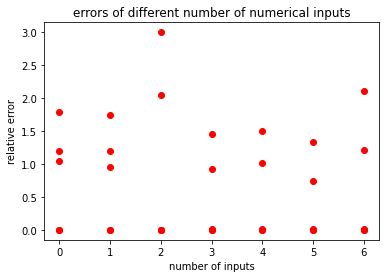

In [69]:
print(errors)
plt.plot(list(range(nvars)), errors, 'ro') # *** need to fix indexes --> from 1 to nvars
# *** fix this to plot relative error at the end of the DLG process
plt.title('errors of different number of numerical inputs')
plt.xlabel('number of inputs')
plt.ylabel('relative error')
plt.savefig('train_DLG_16_big_norm.png', dpi=300)
plt.show()

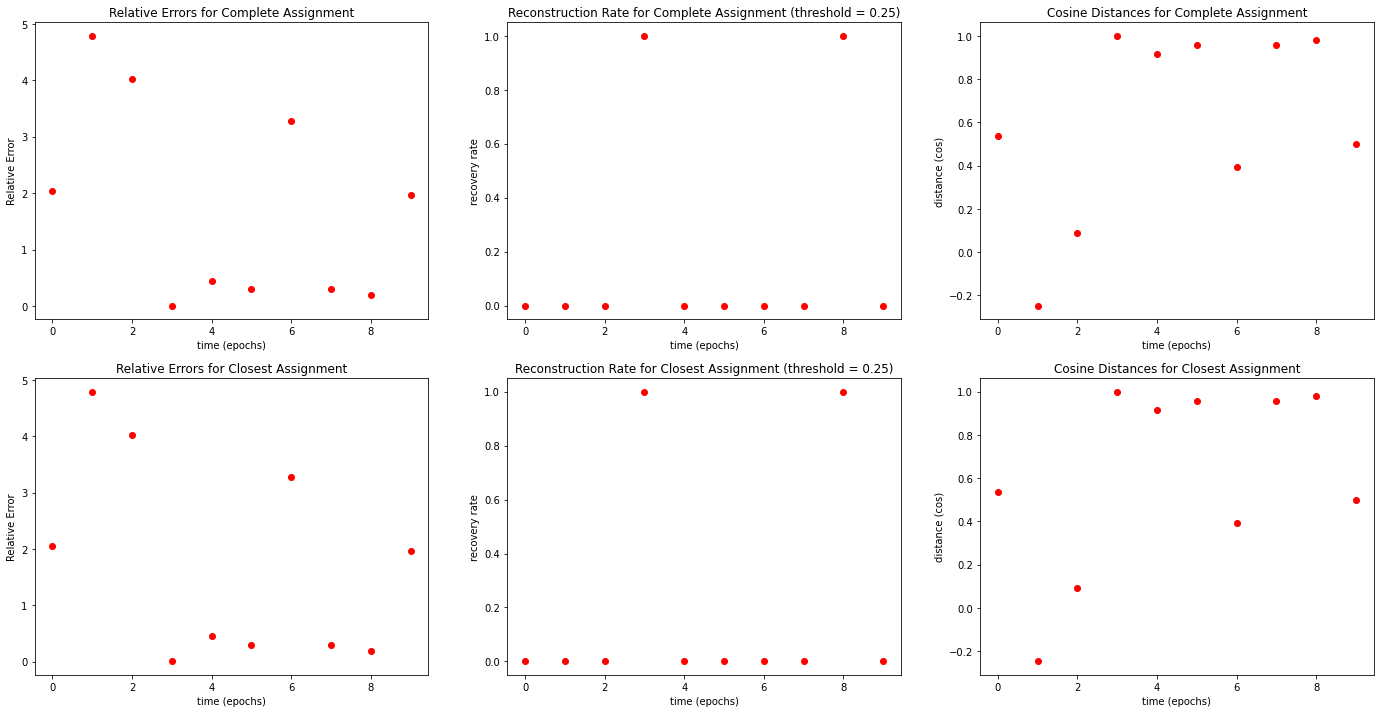

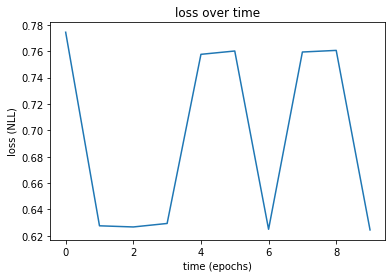

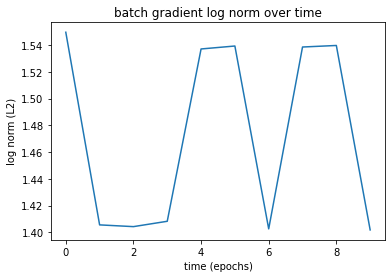

In [ ]:
# create summary plots of MSE and normalized errors over time
fig, axs = plt.subplots(2, 3, figsize=(8*3, 6*2))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro')
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro')
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro')
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro')
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro')
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro')
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

plt.savefig('train_BRAZPD_1.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_BRAZPD_1_loss.png', dpi=300)
plt.show()

plt.plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
plt.title('batch gradient log norm over time')
plt.xlabel('time (epochs)')
plt.ylabel('log norm (L2)')
plt.savefig('train_DLG_16_big_norm.png', dpi=300)
plt.show()

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo
#
# --> randomly sample n features from the baseline set (combine both numerical and categorical variables)
#***--> add more inputs + samples per fixed input
# run the DLG on the brazpd dataset with all the baseline features (multiple interations) for motivation on looking at the number of inputs correlated with the DLG strength
# (not super important) - onehot encoding add an extra bit to indicate missing entry

# future tasks -----------------------------------------------------------
# possibly modify single batch DLG rather than having to run DLG Evolution (debugging purposes --> can already simulate on DLG evolution epochs=1)
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)